In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import random
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import mglearn

In [2]:
# read review dataset and gold labels dataset

data = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/basic_DELL_data.csv')
data = data.rename(columns={"DELL": "REVIEW"})
lab = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/GOLD_DELL_LABELS.csv')

In [4]:
#data = data.rename(columns={'HP': 'REVIEW'})

In [3]:
# merge review and gold labels dataset into one

data['LABELS'] = lab['LABELS']
dd = {0: 'neg', 1: 'pos'}
data['LABELS'] = lab['LABELS'].map(dd)

In [4]:
data.head()

,REVIEW,LABELS
0,Using it for last 4~5 days. This is my 4th lap...,neg
1,I got a detective laptop .It didn't turn on an...,neg
2,"guys , i bought this dell g3 3500 laptop a wee...",pos
3,After using it for about a month..\nGood specs...,pos
4,"Using this product for 10 days,no issues at al...",pos


In [5]:
# glimpse a review

data['REVIEW'][3]

'After using it for about a month..\nGood specs and performance.\nscreen looks dull at first but after disabling eco screen from boot menu looks great.\nprice is somewhat high than others but with the quality you get it is worth it.\nsound is awesome with Alienware controls , keyboard is nice, USB ports are tight at first but works nice after 2-3 days.. only downgrad here is battery performance but guys its gaming system so it can be neglected.\ntried with many games, runs smoother, you need to disable power saving option to get more then 30 fps.. its in nvidia game experince control.\nDelivery here was late but very happy with what i got. Thanks to Amazon and delivey agents '

In [6]:
# OOP program

class L_stats(object):
    def __init__(self, raw, col_name):
        self.raw = raw
        self.col_name = col_name
        
    def tokenized(self):
        tokens = []
        for review in self.raw[self.col_name]:
            tokens.append([w.lower() for w in nltk.word_tokenize(review) if len(w)>2])
        return tokens
    
    def bi_token(self):
        bitokens = []
        tokendata = self.tokenized()
        for review in tokendata:
            bitokens.append(list(nltk.bigrams(review)))
        return bitokens
    
    def vocab(self):
        voc = []
        for review in self.raw[self.col_name]:
            voc += [w.lower() for w in nltk.word_tokenize(review) if len(w)>2]
        return voc
    
    def tokenized_uni(self):
        tokens = []
        for review in self.raw[self.col_name]:
            tokens.append(list(set([w.lower() for w in nltk.word_tokenize(review) if len(w)>2])))
        return tokens
    
    def vocab_uni(self):
        voc = []
        for review in self.raw[self.col_name]:
            voc += [w.lower() for w in nltk.word_tokenize(review) if len(w)>2]
        return list(set(voc))
    
    def avg_word_count(self):
        avg = 0
        v = self.tokenized()
        for review in v:
            avg += (len(review)/len(v))
        avg = np.round(avg, 2)
        return avg
    
    def tokenized_no_stops(self):
        DF = []
        c = self.tokenized()
        for r in c:
            DF.append([w.lower() for w in r if w.lower() not in stopwords.words('english')])
        return DF
    
    def vocab_no_stops(self):
        v = self.vocab()
        d = [w.lower() for w in v if w.lower() not in stopwords.words('english')]
        return d
    
    def count_stats(self):
        print("Total number of words in all reviews: ", len(self.vocab()))
        print()
        print("Average number of words in each review: ", self.avg_word_count())
        print()
        print("Total number of words in all reviews without stopwords", len(self.vocab_no_stops()))
         
    def frequencies(self):
        print("Top 60 most frequently occurring words in the dataset, along with their count:")
        print()
        var2 = nltk.FreqDist(self.vocab()).most_common(60)
        for i in range(60):
            print(var2[i])
    
    def frequencies_stop(self):
        print("Top 30 most frequently occurring words in the data without stops, along with their count:")
        print()
        var = nltk.FreqDist(self.vocab_no_stops()).most_common(30)
        for i in range(30):
            print(var[i])
    
    def hapaxes(self):
        print("Top 60 most rare words that occur only once in the review dataset:")
        print()
        vvv = self.vocab()
        var3 = nltk.FreqDist(vvv).hapaxes()
        for i in range(60):
            print(var3[i])
            
    def collocation(self):
        print("Most frequent bigrams (pairs of words): ")
        print()
        v4 = self.vocab()
        t = nltk.Text(v4)
        print(t.collocations_list())
        #print()
        #dft = self.tokenized()
        #for r in dft:
            #t = nltk.Text(r)
            #if t.collocations() != None:
                #print(t.collocations())
                
    def concord(self, word):
        vs = self.vocab()
        tt = nltk.Text(vs)
        print(tt.concordance(word))
        
    def find_bigrams(self, word):
        vv = self.vocab()
        t6 = nltk.Text(vv)
        print(t6.findall(r'<{}> <.*>'.format(word)))
        
    def nouns(self):
        vvs = self.vocab()
        nouns = [w for (w, n) in nltk.pos_tag(vvs) if n in ['NN', 'NNP']]
        return nouns

In [7]:
# create main object

DATA = L_stats(data, 'REVIEW')

In [8]:
# extract all tokenized reviews for training 

DFL = DATA.tokenized_no_stops()
reviews_all = []
for i in range(len(data['LABELS'])):
    reviews_all.append((DFL[i], data['LABELS'][i]))

In [9]:
# shuffle the reviews

random.shuffle(reviews_all)

In [10]:
# get best features

freq_words = nltk.FreqDist(DATA.vocab_no_stops())
word_features = list(freq_words)

In [11]:
# define training output and condition

def review_features(review, w_feat):
    review_words = set(review)
    features = {}
    for word in w_feat:
        features['contains({})'.format(word)] = (word in review_words)
    return features

In [12]:
# train model

feature_sets = [(review_features(r, word_features), c) for (r, c) in reviews_all]
train_set, test_set = feature_sets[:400], feature_sets[400:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [13]:
# get accuracy

nltk.classify.accuracy(classifier, test_set)

0.7878787878787878

In [14]:
# get informative features

classifier.show_most_informative_features(20)

Most Informative Features
      contains(customer) = True              neg : pos    =     15.8 : 1.0
         contains(worst) = True              neg : pos    =     10.7 : 1.0
          contains(poor) = True              neg : pos    =     10.2 : 1.0
       contains(amazing) = True              pos : neg    =      8.3 : 1.0
     contains(excellent) = True              pos : neg    =      8.3 : 1.0
          contains(nice) = True              pos : neg    =      7.7 : 1.0
          contains(came) = True              neg : pos    =      6.9 : 1.0
          contains(home) = True              neg : pos    =      6.9 : 1.0
       contains(replace) = True              neg : pos    =      6.9 : 1.0
         contains(today) = True              neg : pos    =      6.9 : 1.0
         contains(waste) = True              neg : pos    =      6.9 : 1.0
       contains(awesome) = True              pos : neg    =      6.9 : 1.0
       contains(looking) = True              pos : neg    =      5.8 : 1.0

In [13]:
# read the lexicons datasets

lex1 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/N_NEG_LEX.csv')
lex2 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/N_POS_LEX.csv')
lex3 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/onlyNEG.csv')
lex4 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/onlyPOS.csv')

In [14]:
# separate out the words in separate positive negative lexicons

negative_NEG = list(lex1['word'])
positive_NEG = list(lex2['word'])
negative_ONLY = list(lex3['word'])
positive_ONLY = list(lex4['word'])

In [15]:
# read the negation bigram lexicons

lex5 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/bi_NEG.csv')
lex6 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/bi_POS.csv')

In [16]:
# separate out the bigrams into separate positive negative lexicons

neg_bi = [tuple(x) for x in list(lex5.values)]
pos_bi = [tuple(x) for x in list(lex6.values)]

In [17]:
# store data in unigram and bigram formats

bigrams_data = DATA.bi_token()
unigrams_data = DATA.tokenized()

In [20]:
# latent semantic indexing to isolate "topics"

regex = r'[a-zA-Z]{4,17}'
vect = CountVectorizer(max_df=0.36, stop_words="english", token_pattern=regex)
X = vect.fit_transform(data['REVIEW'])

In [21]:
lda = LatentDirichletAllocation(n_components=3, learning_method="batch",
                                max_iter=30, random_state=0)
doc_topics = lda.fit_transform(X)

In [22]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

In [23]:
mglearn.tools.print_topics(topics=range(3), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=3, n_words=40)

topic 0       topic 1       topic 2       
--------      --------      --------      
good          good          dell          
battery       dell          product       
product       product       battery       
performance   screen        amazon        
best          really        time          
nice          office        days          
fast          gaming        working       
dell          keyboard      issue         
great         display       support       
price         like          performance   
quality       just          poor          
money         performance   issues        
design        amazon        like          
life          time          quality       
light         using         replacement   
display       work          screen        
awesome       overall       model         
really        issue         charging      
like          sound         disappointed  
amazing       configuration problem       
value         price         worst         
heating    

In [18]:
# sentence collection using checklists

checklist1 = ["customer", "customers", "care", "support", "service", "uses", "users",
             "replaced", "replacement", "services", "replace", "subscription",
             "recommend", "delivered", "received", "amazon", "issue", ]

checklist2 = ["hardware", "defective", "charging", "crashed", "error", "heated", "technical", "updated",
              "machine", "adapter", "browser", "draining", "faulty", "flickering", "freezing",
              "hanging", "lagging", "speed", "drivers", "charger", "jack", "charge", "portable",
              "software", "sensor", "power" "graphic", "games", "cooling", "office", "scanner",
              "sound", "configuration", "ports", "heat"]

checklist3 = ["premium", "looks", "weight", "heavy", "looking", "build", "design",
              "lid", "lasted", "sleek", "metal", "white", "blue", "colour", "quality",
              "money", "price", "value", "worth", "bucks", "cost", "range", "light"]


f1_sents = []
for i in range(len(unigrams_data)):
    for w in checklist1:
        if w in unigrams_data[i] and unigrams_data[i] not in f1_sents:
            f1_sents.append(unigrams_data[i])
            
f2_sents = []
for i in range(len(unigrams_data)):
    for w in checklist2:
        if w in unigrams_data[i] and unigrams_data[i] not in f2_sents:
            f2_sents.append(unigrams_data[i])
            
f3_sents = []
for i in range(len(unigrams_data)):
    for w in checklist3:
        if w in unigrams_data[i] and unigrams_data[i] not in f3_sents:
            f3_sents.append(unigrams_data[i])

In [19]:
# separating the data into - sentences with negation bigrams and sentences without

f1_w_negs = []
f1_wo_negs = []
POS_BI = set(pos_bi)
NEG_BI = set(neg_bi)
lean = False

#### feature 1 ####

for i in range(len(f1_sents)):
    big = list(nltk.bigrams(f1_sents[i]))
    BIG = set(big)
    if len(set.intersection(BIG, POS_BI)) > 0 or len(set.intersection(BIG, NEG_BI)) > 0:
        if f1_sents[i] not in f1_w_negs:
            f1_w_negs.append(f1_sents[i])
    elif len(set.intersection(BIG, POS_BI)) == 0 and len(set.intersection(BIG, NEG_BI)) == 0:
        if f1_sents[i] not in f1_wo_negs:
            f1_wo_negs.append(f1_sents[i])
            
#### feature 2 ######
            
f2_w_negs = []
f2_wo_negs = []
            
for i in range(len(f2_sents)):
    big = list(nltk.bigrams(f2_sents[i]))
    BIG = set(big)
    if len(set.intersection(BIG, POS_BI)) > 0 or len(set.intersection(BIG, NEG_BI)) > 0:
        if f2_sents[i] not in f2_w_negs:
            f2_w_negs.append(f2_sents[i])
    elif len(set.intersection(BIG, POS_BI)) == 0 and len(set.intersection(BIG, NEG_BI)) == 0:
        if f2_sents[i] not in f2_wo_negs:
            f2_wo_negs.append(f2_sents[i])
            
#### feature 3 ####
            
f3_w_negs = []
f3_wo_negs = []
    
for i in range(len(f3_sents)):
    big = list(nltk.bigrams(f3_sents[i]))
    BIG = set(big)
    if len(set.intersection(BIG, POS_BI)) > 0 or len(set.intersection(BIG, NEG_BI)) > 0:
        if f3_sents[i] not in f3_w_negs:
            f3_w_negs.append(f3_sents[i])
    elif len(set.intersection(BIG, POS_BI)) == 0 and len(set.intersection(BIG, NEG_BI)) == 0:
        if f3_sents[i] not in f3_wo_negs:
            f3_wo_negs.append(f3_sents[i])

In [20]:
# algorithm that counts the score of each feature

# this algorithm counts the score of "negation bigrams"
# and returns a score tuple of (positive-negation-bigrams) and (negative-negation-bigrams)

def negation_score(negation_list, positive_NEG, negative_NEG):
    dataset = pd.DataFrame(columns=['REVIEW', 'score'])
    for i in range(len(negation_list)):
        p_score = 0
        n_score = 0
        bb = list(nltk.bigrams(negation_list[i]))
        for br in bb:
            if br in pos_bi:
                n_score -= 1
            elif br in neg_bi:
                p_score += 1
        
        for w in negation_list[i]:
            if w in positive_NEG:
                p_score += 1
            elif w in negative_NEG:
                n_score -= 1
                
        dataset.loc[i] = [" ".join(negation_list[i]), p_score + n_score]
        
    return dataset

D11 = negation_score(f1_w_negs, positive_NEG, negative_NEG)
D21 = negation_score(f2_w_negs, positive_NEG, negative_NEG)
D31 = negation_score(f3_w_negs, positive_NEG, negative_NEG)

In [21]:
# algorithm that counts the score of each feature

# this algorithm counts the score of "unigrams"
# it returns a score tuple of (positive-unigrams) and (negative unigrams)

def pure_score(non_neg_list, positive_ONLY, negative_ONLY):
    dataset = pd.DataFrame(columns=['REVIEW', 'score'])
    
    for i in range(len(non_neg_list)):
        p_score = 0
        n_score = 0
        for w in non_neg_list[i]:
            if w in positive_ONLY:
                p_score += 1
            elif w in negative_ONLY:
                n_score -= 1
                
        dataset.loc[i] = [" ".join(non_neg_list[i]), p_score + n_score]
        
    return dataset

D12 = pure_score(f1_wo_negs, positive_ONLY, negative_ONLY)
D22 = pure_score(f2_wo_negs, positive_ONLY, negative_ONLY)
D32 = pure_score(f3_wo_negs, positive_ONLY, negative_ONLY)

In [22]:
# convert original dataset to a review format similar to the tokenized reviews

rev = []
label = []
data_new = pd.DataFrame(columns=['REVIEW', 'LABELS'])
for i in range(len(data)):
    rev.append(" ".join(unigrams_data[i]))
    label.append(data['LABELS'][i])
    
data_new['REVIEW'] = rev
data_new['LABELS'] = label

In [23]:
# concatenate pure and negation scores of each feature into feature wise datasets

feature1 = pd.concat([D11, D12], axis=0).reset_index(drop=True)
feature2 = pd.concat([D21, D22], axis=0).reset_index(drop=True)
feature3 = pd.concat([D31, D32], axis=0).reset_index(drop=True)

In [24]:
feature3.score.median()

2.0

In [25]:
# merge all the data into one final dataset with columns for features

d1 = pd.merge(feature1, feature2, on="REVIEW", how="outer")
d1 = d1.rename({'score_x': 'customers', 'score_y': 'performance'}, axis=1)
FINAL = d1.merge(feature3, on="REVIEW", how="outer")
FINAL = FINAL.rename({'score': 'appearance_price'}, axis=1)

In [26]:
score_arr = []
for i in range(len(FINAL['REVIEW'])):
    for j in range(1, 4):
        if type(FINAL.iloc[i][j]) == int:
            a = FINAL.iloc[i][j]
            FINAL.iloc[i][j] = 1
        elif type(FINAL.iloc[i][j]) != int:
            FINAL.iloc[i][j] = 0
    score_arr.append(a)
FINAL['SCORE'] = score_arr

In [27]:
lab = []
for i in range(len(FINAL['REVIEW'])):
    if FINAL['SCORE'][i] <= 0:
        lab.append("neg")
    elif FINAL['SCORE'][i] > 0:
        lab.append("pos")

(array([  1.,   0.,   1.,  30.,  98., 159.,  59.,  15.,   6.,   6.]),
 array([-14., -11.,  -8.,  -5.,  -2.,   1.,   4.,   7.,  10.,  13.,  16.]),
 <a list of 10 Patch objects>)

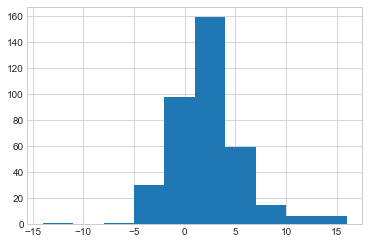

In [33]:
plt.hist(FINAL['SCORE'])

In [28]:
FINAL['LABELS'] = lab

In [29]:
FINAL.head()

,REVIEW,customers,performance,appearance_price,SCORE,LABELS
0,using for last 4~5 days this 4th laptop main u...,1,1,1,1,pos
1,guys bought this dell 3500 laptop week ago fro...,1,1,1,1,pos
2,overall products was good but when was receive...,1,0,0,-5,neg
3,this laptop good almost all terms though not g...,1,1,1,1,pos
4,purchased the base varient dell 3500 10th gen ...,1,1,1,9,pos


In [30]:
VALID = pd.merge(data_new, FINAL[['REVIEW', 'LABELS']], on='REVIEW', how='inner')

In [32]:
brand = []
for i in range(len(FINAL['REVIEW'])):
    brand.append("DELL")
FINAL['brand'] = brand

FINAL.head()

,REVIEW,customers,performance,appearance_price,SCORE,LABELS,brand
0,using for last 4~5 days this 4th laptop main u...,1,1,1,1,pos,DELL
1,guys bought this dell 3500 laptop week ago fro...,1,1,1,1,pos,DELL
2,overall products was good but when was receive...,1,0,0,-5,neg,DELL
3,this laptop good almost all terms though not g...,1,1,1,1,pos,DELL
4,purchased the base varient dell 3500 10th gen ...,1,1,1,9,pos,DELL


In [64]:
# set the method labels based on median comparison

#lab = []
#for i in range(len(FINAL['REVIEW'])):
#    if (FINAL.iloc[i][1]<=0.0)or(FINAL.iloc[i][2]<=1.0)or(FINAL.iloc[i][3]<=0.0):
#        lab.append("neg")
#    elif (FINAL.iloc[i][1]>0.0)or(FINAL.iloc[i][2]>1.0)or(FINAL.iloc[i][3]>0.0):
#        lab.append("pos")

In [65]:
#FINAL['LABELS'] = lab

In [66]:
# merging method label dataset with actual gold labeled dataset

#VALID = pd.merge(data_new, FINAL[['REVIEW', 'LABELS']], on='REVIEW', how='inner')

In [31]:
# getting the accuracy of method labels with respect to the gold labels

counter = 0
for i in range(len(VALID)):
    if VALID['LABELS_x'][i] == VALID['LABELS_y'][i]:
        counter += 1
    else:
        pass
    
print(counter/len(VALID))

0.8351063829787234


In [39]:
FINAL

,REVIEW,customers,performance,appearance_price,SCORE,LABELS
0,using for last 4~5 days this 4th laptop main u...,1,1,1,1,pos
1,guys bought this dell 3500 laptop week ago fro...,1,1,1,1,pos
2,overall products was good but when was receive...,1,0,0,-5,neg
3,this laptop good almost all terms though not g...,1,1,1,1,pos
4,purchased the base varient dell 3500 10th gen ...,1,1,1,9,pos
...,...,...,...,...,...,...
370,elegant looks smooth operating happy till now,0,0,1,3,pos
371,very good product 60k range,0,0,1,1,pos
372,very nice product battery and performance also...,0,0,1,4,pos
373,just one word ... wow amazing laptop wanted th...,0,0,1,6,pos


In [33]:
FINAL.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/master_DELL.csv')

In [269]:
from venn import venn

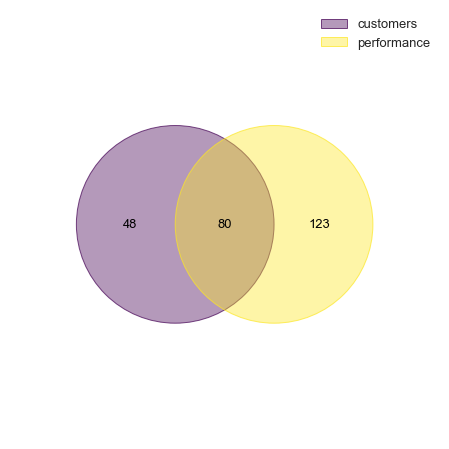

In [392]:
# 2 way VENN diagrams

H_12 = {'customers': set(feature1['REVIEW']), 'performance': set(feature2['REVIEW'])}
venn(H_12)

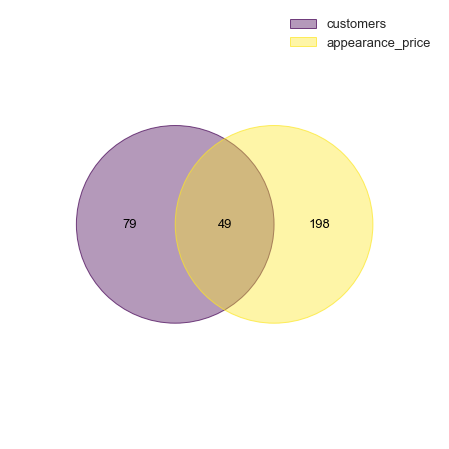

In [393]:
H_22 = {'customers': set(feature1['REVIEW']), 'appearance_price': set(feature3['REVIEW'])}
venn(H_22)

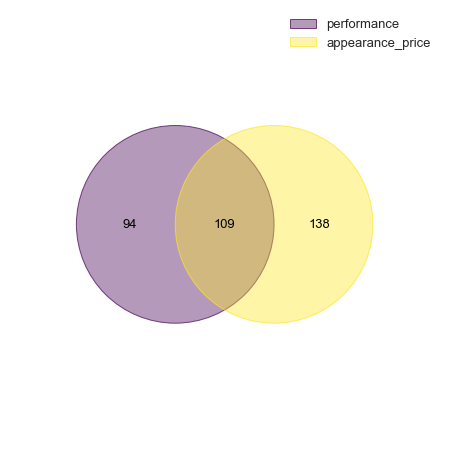

In [394]:
H_32 = {'performance': set(feature2['REVIEW']), 'appearance_price': set(feature3['REVIEW'])}
venn(H_32)

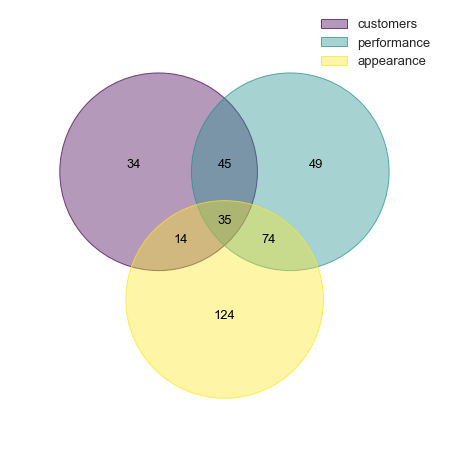

In [395]:
# three way VENN diagrams

H_13 = {'customers': set(feature1['REVIEW']), 'performance': set(feature2['REVIEW']),
        'appearance': set(feature3['REVIEW'])}
venn(H_13)

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [42]:
sentence_data = []
for rev in data['REVIEW']:
    sents = nltk.sent_tokenize(rev)
    R = []
    for s in sents:
        R.append(s)
    sentence_data.append(R)

In [398]:
list(sia.polarity_scores(sentence_data[1][0]).values())[3]

-0.5719

In [43]:
dd = pd.DataFrame(columns=['rev', 'lab'])
rev1 = []
lab1 = []
for sent in sentence_data:
    c = 0
    for s in sent:
        score = list(sia.polarity_scores(s).values())[3]
        c += score
    if c <= 0:
        rev1.append(" ".join(sent))
        lab1.append('neg')
    elif c > 0:
        rev1.append(" ".join(sent))
        lab1.append("pos")
    
dd['rev'] = rev1
dd['lab'] = lab1

In [63]:
dd

,rev,lab
0,Using it for last 4~5 days. This is my 4th lap...,pos
1,I got a detective laptop .It didn't turn on an...,neg
2,"guys , i bought this dell g3 3500 laptop a wee...",pos
3,After using it for about a month..\nGood specs...,pos
4,"Using this product for 10 days,no issues at al...",pos
...,...,...
494,There is no MS home and office included in the...,pos
495,In product descriptiom SSD drive was included ...,neg
496,This product doesn’t have MS office. When I co...,pos
497,"Has a premium look , sleek and fast processing.",neg


In [44]:
rev2 = []
label2 = []
data_new2 = pd.DataFrame(columns=['REVIEW', 'LABELS'])
for i in range(len(data)):
    rev2.append(" ".join(unigrams_data[i]))
    label2.append(dd['lab'][i])
    
data_new2['REVIEW'] = rev2
data_new2['LABELS'] = label2

In [66]:
data_new2

,REVIEW,LABELS
0,using for last 4~5 days this 4th laptop main u...,pos
1,got detective laptop .it did n't turn and had ...,neg
2,guys bought this dell 3500 laptop week ago fro...,pos
3,after using for about month good specs and per...,pos
4,using this product for days issues all the lap...,pos
...,...,...
494,there home and office included the product and...,pos
495,product descriptiom ssd drive was included but...,neg
496,this product doesn have office when contacted ...,pos
497,has premium look sleek and fast processing,neg


In [45]:
VALID2 = pd.merge(data_new, data_new2[['REVIEW', 'LABELS']], on='REVIEW', how='inner')

In [68]:
VALID2

,REVIEW,LABELS_x,LABELS_y
0,using for last 4~5 days this 4th laptop main u...,neg,pos
1,got detective laptop .it did n't turn and had ...,neg,neg
2,guys bought this dell 3500 laptop week ago fro...,pos,pos
3,after using for about month good specs and per...,pos,pos
4,using this product for days issues all the lap...,pos,pos
...,...,...,...
506,there home and office included the product and...,neg,pos
507,product descriptiom ssd drive was included but...,neg,neg
508,this product doesn have office when contacted ...,neg,pos
509,has premium look sleek and fast processing,pos,neg


In [46]:
# accuracy of labels computed using VADER

counter = 0
for i in range(len(VALID2)):
    if VALID2['LABELS_x'][i] == VALID2['LABELS_y'][i]:
        counter += 1
    else:
        pass
    
print(counter/len(VALID2))

0.8395303326810176
